
### Question :-
Write a new network that
has the architecture to C1C2C3C4O (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
total RF must be more than 44
one of the layers must use Depthwise Separable Convolution
one of the layers must use Dilated Convolution
use GAP (compulsory):- add FC after GAP to target #of classes (optional)
use albumentation library and apply:
horizontal flip
shiftScaleRotate
coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.  

Here C1, C2, C3, C4 are conv blocks that have multiple layers of conv  
O is Output layer (last layer)



With params =  ; on th epoch, test_acc = %    
### Note :-
Comment print statement in the below two functions in code to get shape of each layer to be printed ...
#### Original code :
    def printf(self, n, x):
      print(f"{n} " f"{x.shape = }") ##  Comment / Uncomment this line towards the no need of print or needed print
      pass
    def printEmpty(self,):
      print("") ##  Comment / Uncomment this line towards the no need of print or needed print
      pass               

#### Modified code :
    def printf(self, n, x):
      # print(f"{n} " f"{x.shape = }") ##  Comment / Uncomment this line towards the no need of print or needed print
      pass
    def printEmpty(self,):
      # print("") ##  Comment / Uncomment this line towards the no need of print or needed print
      pass     

# 1. Import external libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import imgaug as ia
from imgaug import augmenters as iaa
from albumentations.pytorch import ToTensorV2
from torch.utils.data import ConcatDataset, DataLoader

#### Basically working model
#### Img Aug RandomRotation
#### StepLR Scheduler
#### Train & Test Graphs

# 2. Convolutional Neural Network (model) architecture

### How to find RF (Receptive Field) of advanced convolutions
RF of Dilated Conv :-  
https://stats.stackexchange.com/questions/265462/whats-the-receptive-field-of-a-stack-of-dilated-convolutions/267752#267752  
sl0=1
sli=sli+(kernelsize−1)⋅dilationfactor

https://distill.pub/2019/computing-receptive-fields/  
The receptive field properties of the separable convolution are identical to its corresponding equivalent non-separable convolution.In fact, the same holds good with depthwise convolutions too.

In [ ]:
!wget https://raw.githubusercontent.com/rajayourfriend/EraV2/main/S9/model.py
!ls model.py

--2024-03-29 19:07:28--  https://raw.githubusercontent.com/rajayourfriend/EraV2/main/S9/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19373 (19K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]  18.92K  --.-KB/s    in 0s      

2024-03-29 19:07:28 (100 MB/s) - ‘model.py’ saved [19373/19373]

model.py


In [ ]:
import model

#### RuntimeError: running_mean should contain 8 elements not 4
Implies check the bn channels, whether it matches with the ouput channel of its previous layer.

# 3. Display summary of model

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() #bool
str_gpu_cpu = "cuda" if use_cuda else "cpu" #string
device = torch.device(str_gpu_cpu)
print("device is " + str_gpu_cpu)
model = model.Net_S9().to(device)
summary(model, input_size=(3, 32, 32))

device is cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
       BatchNorm2d-2            [-1, 3, 32, 32]               6
              ReLU-3            [-1, 3, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]             192
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]             576
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           4,096
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 30, 30]          36,928
          Dropout-14    

/content/model.py:158: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


If below error comes :

RuntimeError: Given input size: (10x4x4). Calculated output size: (10x0x0). Output size is too small

==> Check the GAP argument

# 4. Preparation of dataset  

In [ ]:

SEED = 1
torch.manual_seed(SEED)
batch_size = 32
batch_size = 128
batch_size = 64

# Reference Code :-
# https://albumentations.ai/docs/autoalbument/examples/cifar10/
# https://www.kaggle.com/code/ar2017/pytorch-efficientnet-train-aug-cutmix-fmix

# https://github.com/ishwarraja/SOAI-ERAV2/blob/main/S9/Assignment/Albument.py

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class ImageDataset(datasets.CIFAR10):
    def __init__(self, root="~/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label

train_transform1 = A.Compose([
    # A.HorizontalFlip(),
    # A.ShiftScaleRotate(),
    # A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,
    #                 fill_value=0.5, mask_fill_value=None),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

train_transform2 = A.Compose([
    A.HorizontalFlip(),
    A.ShiftScaleRotate(),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,
                    fill_value=0.5, mask_fill_value=None),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

train_dataset1 = ImageDataset(root='./data', train=True, download=True, transform=train_transform1)
train_dataset2 = ImageDataset(root='./data', train=True, download=True, transform=train_transform2)
train_dataset = ConcatDataset((train_dataset1, train_dataset2))

test_dataset = ImageDataset(root='./data', train=False, download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 77858041.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"train_dataset.len={len(train_dataset)}")

train_dataset.len=100000


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshowfor10(img, predlbl, tglbl):
    rows = 5
    columns = 2
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        ax = fig.add_subplot(rows, columns, i)
        # print("img.type = " + str(type(img)))
        # print("img.len = " + str(len(img)))
        # print("img.shape = " + str(np.asarray(img).shape))
        tmpimg = img[i-1] / 2 + 0.5     # unnormalize
        npimg = tmpimg.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        lbls = str("pred=" + predlbl[i-1]) + " ,  " + "target=" +str(tglbl[i-1])
        ax.set_xlabel(lbls)
    plt.show()

<class 'torch.utils.data.dataloader.DataLoader'>


<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
<class 'torch.Tensor'>


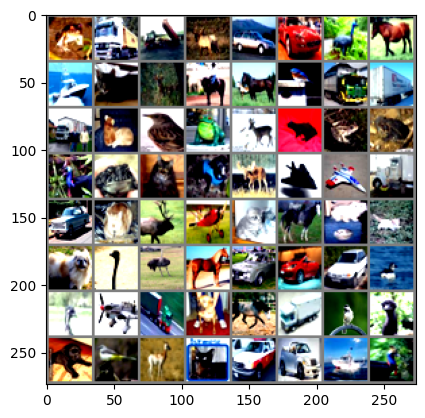

frog  truck truck deer  car   car   bird  horse ship  cat   deer  horse horse bird  truck truck truck cat   bird  frog  deer  cat   frog  frog  bird  frog  cat   dog   deer  plane plane truck car   cat   deer  plane cat   horse cat   cat   dog   bird  bird  horse car   car   car   bird  bird  plane truck dog   horse truck bird  bird  dog   bird  deer  cat   car   car   ship  bird 


In [ ]:
print(type(trainloader))

#random sample from data from training images
dataiter = iter(trainloader)
print(type(dataiter))
#dir(dataiter)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(type(labels))
imshow(utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 5. Train and Test Functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
global ngimg
global nglabel
global tglabel

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Batch_id = {batch_idx} train_acc = {100*correct/processed:0.2f}%')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    ngimg = []
    nglabel = []
    tglabel = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_losses.append(test_loss)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            ng = pred.ne(target.view_as(pred))
            n = len(ng)
            ngimg += [iter[j] for iter in [data] for j in range(n) if ng[j] == True]
            nglabel += [classes[pred[j]] for j in range(n) if ng[j] == True]
            tglabel += [classes[target[j]] for j in range(n) if ng[j] == True]

    test_loss /= len(test_loader.dataset)

    print('\n  Test set: Average loss: {:.4f}, test_acc = ({:.2f}%)\n'.format(
        test_loss,
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))
    return [ngimg, nglabel, tglabel]



# 6. Run the model with a device and an optimizer

In [ ]:

print(f"trainloader1.type={type(trainloader)}")
# print(f"trainloader2.type={type(trainloader2)}")

print(f"trainloader1.len={len(trainloader)}")
# print(f"trainloader2.len={len(trainloader2)}")

trainloader1.type=<class 'torch.utils.data.dataloader.DataLoader'>
trainloader1.len=1563


In [ ]:


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#RAJA ToDo Try ADAM optimizer
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
result = []

ep = 21
for epoch in range(1, ep):
    print('epoch = {}'.format(epoch))
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    ngimg, nglabel, tglabel = test(model, device, testloader)

epoch = 1


Batch_id = 1562 train_acc = 44.53%: 100%|██████████| 1563/1563 [00:39<00:00, 39.17it/s]



  Test set: Average loss: 1.1391, test_acc = (59.28%)

epoch = 2


Batch_id = 1562 train_acc = 64.03%: 100%|██████████| 1563/1563 [00:40<00:00, 38.28it/s]



  Test set: Average loss: 0.7949, test_acc = (71.95%)

epoch = 3


Batch_id = 1562 train_acc = 70.06%: 100%|██████████| 1563/1563 [00:40<00:00, 38.56it/s]



  Test set: Average loss: 0.7475, test_acc = (73.95%)

epoch = 4


Batch_id = 1562 train_acc = 73.27%: 100%|██████████| 1563/1563 [00:40<00:00, 38.87it/s]



  Test set: Average loss: 0.6831, test_acc = (76.52%)

epoch = 5


Batch_id = 1562 train_acc = 75.19%: 100%|██████████| 1563/1563 [00:40<00:00, 38.72it/s]



  Test set: Average loss: 0.6118, test_acc = (78.83%)

epoch = 6


Batch_id = 1562 train_acc = 76.85%: 100%|██████████| 1563/1563 [00:40<00:00, 38.20it/s]



  Test set: Average loss: 0.5774, test_acc = (80.10%)

epoch = 7


Batch_id = 1562 train_acc = 79.95%: 100%|██████████| 1563/1563 [00:40<00:00, 38.31it/s]



  Test set: Average loss: 0.4707, test_acc = (83.83%)

epoch = 8


Batch_id = 1562 train_acc = 81.08%: 100%|██████████| 1563/1563 [00:40<00:00, 38.97it/s]



  Test set: Average loss: 0.4640, test_acc = (84.10%)

epoch = 9


Batch_id = 1562 train_acc = 81.38%: 100%|██████████| 1563/1563 [00:40<00:00, 38.38it/s]



  Test set: Average loss: 0.4548, test_acc = (84.45%)

epoch = 10


Batch_id = 1562 train_acc = 82.16%: 100%|██████████| 1563/1563 [00:40<00:00, 38.53it/s]



  Test set: Average loss: 0.4540, test_acc = (84.56%)

epoch = 11


Batch_id = 1562 train_acc = 82.11%: 100%|██████████| 1563/1563 [00:39<00:00, 39.28it/s]



  Test set: Average loss: 0.4539, test_acc = (84.42%)

epoch = 12


Batch_id = 1562 train_acc = 82.71%: 100%|██████████| 1563/1563 [00:39<00:00, 39.44it/s]



  Test set: Average loss: 0.4507, test_acc = (84.86%)

epoch = 13


Batch_id = 1562 train_acc = 82.74%: 100%|██████████| 1563/1563 [00:39<00:00, 39.14it/s]



  Test set: Average loss: 0.4444, test_acc = (84.89%)

epoch = 14


Batch_id = 1562 train_acc = 82.94%: 100%|██████████| 1563/1563 [00:40<00:00, 38.27it/s]



  Test set: Average loss: 0.4415, test_acc = (85.03%)

epoch = 15


Batch_id = 1562 train_acc = 83.09%: 100%|██████████| 1563/1563 [00:39<00:00, 39.08it/s]



  Test set: Average loss: 0.4407, test_acc = (85.10%)

epoch = 16


Batch_id = 1562 train_acc = 83.12%: 100%|██████████| 1563/1563 [00:41<00:00, 38.02it/s]



  Test set: Average loss: 0.4425, test_acc = (85.01%)

epoch = 17


Batch_id = 1562 train_acc = 83.15%: 100%|██████████| 1563/1563 [00:40<00:00, 38.68it/s]



  Test set: Average loss: 0.4409, test_acc = (85.07%)

epoch = 18


Batch_id = 1562 train_acc = 83.23%: 100%|██████████| 1563/1563 [00:41<00:00, 37.42it/s]



  Test set: Average loss: 0.4414, test_acc = (85.20%)

epoch = 19


Batch_id = 1562 train_acc = 83.35%: 100%|██████████| 1563/1563 [00:39<00:00, 39.29it/s]



  Test set: Average loss: 0.4383, test_acc = (85.24%)

epoch = 20


Batch_id = 1562 train_acc = 83.30%: 100%|██████████| 1563/1563 [00:40<00:00, 38.43it/s]



  Test set: Average loss: 0.4392, test_acc = (85.25%)



Find 10 misclassified images for the BN, GN and LN model and show them as a 5x2 image matrix in separately annotated images

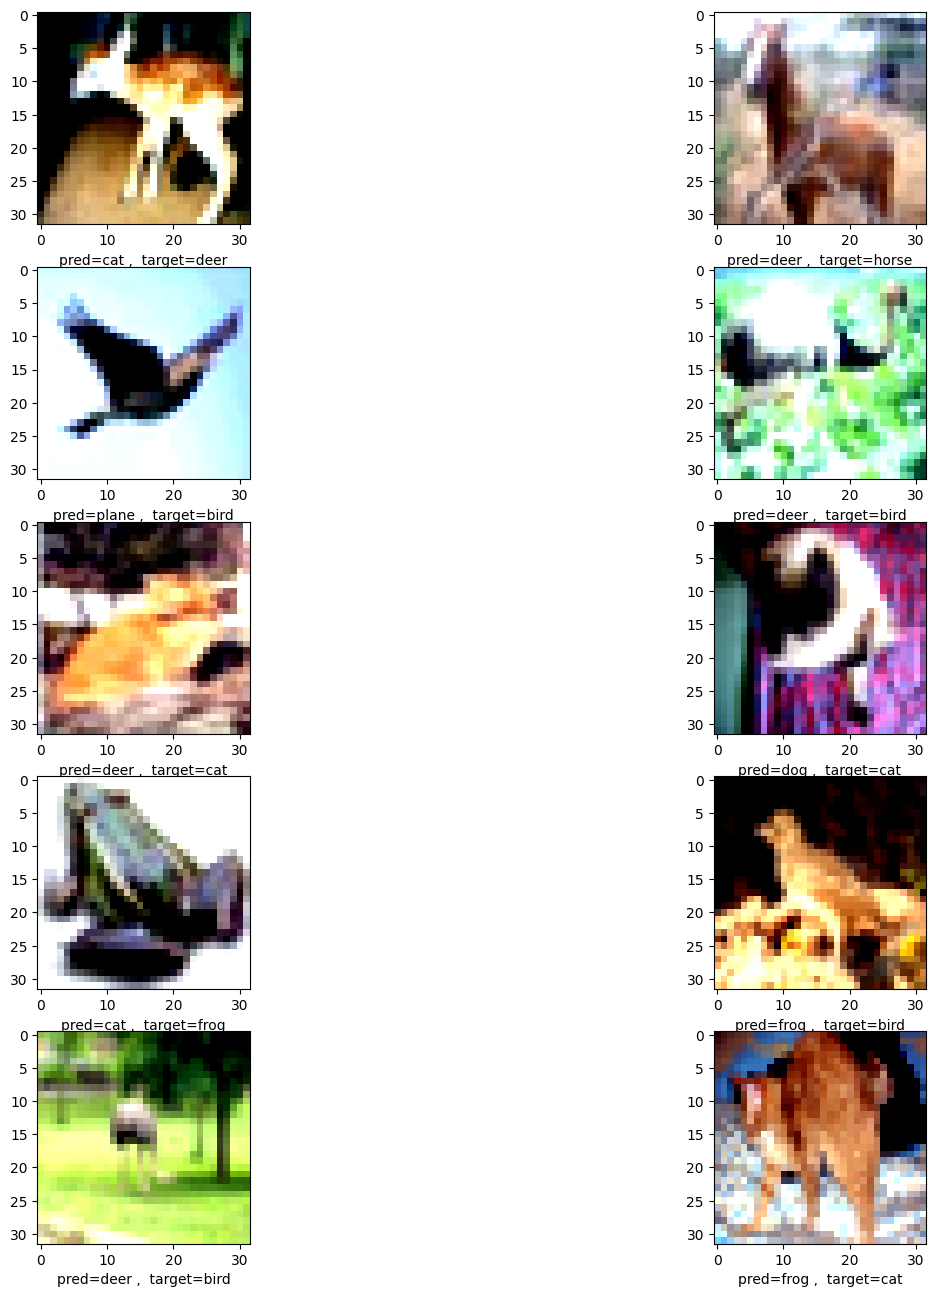

In [ ]:


ngimg10 = torch.stack(ngimg[-10:])
nglabel10 = nglabel[-10:]
tglabel10 = tglabel[-10:]
ngimg10 = ngimg10.cpu()
imshowfor10(ngimg10, nglabel10, tglabel10)

In [ ]:
#random sample from data from training images
dataiter = iter(trainloader)
print("dataiter type = " + str(type(dataiter)))


print("ndi len = " + str(len(next(dataiter))))
a, b = next(dataiter)

print("a type = " + str(type(a)))
print("b type = " + str(type(b)))
print("a len = " + str(len(a)))
print("a len = " + str(a.shape))
print("b len = " + str(b.shape))

dataiter type = <class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
ndi len = 2
a type = <class 'torch.Tensor'>
b type = <class 'torch.Tensor'>
a len = 64
a len = torch.Size([64, 3, 32, 32])
b len = torch.Size([64])
